## Kaggle Competition: Histopathologic Cancer Detection

In [1]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

In [21]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.data import train_test_split, get_image_dataloaders, display_image_batch
from src.model import SimpleCNNModel, get_resnet18, save_model, load_model
from src.train import train_model, validate_model

### Prep-processing; only needs to be run once

Assumes there is a directory 'data' with a sub-directory 'train_all' that contains the unzipped 'train.zip'

In [ ]:
train_test_split('data/train_labels.csv', 'data')

## Experiment 1 -  Simple, hand-crafted CNN model

### Load the data

In [46]:
DATA_DIR = 'data/'

data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    'validate': transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
}

dataloader_params = {
    "batch_size": 256,  # Increasing this will yield a CUDA Out-Of-Memory exception
    "shuffle": True,
    "num_workers": 8,
}
dataloaders = get_image_dataloaders(DATA_DIR, transforms=data_transforms, **dataloader_params)

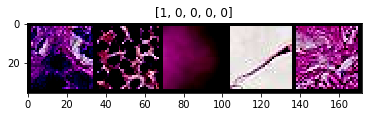

In [47]:
# Display training data

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:5])
display_image_batch(out, title=classes[:5].tolist())

### Prepare the model and training conditions

In [98]:
model_ft = SimpleCNNModel()

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# Display model layers
model_ft

SimpleCNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
)

#### Optional: Load a previously trained model from disk


In [96]:
model_ft = load_model(model_ft, 'SimpleCNNModel')

### Train the model

In [99]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


Epoch: 0 Training Batch: 200 Loss: 0.6804909543018436 Acc: 0.5959460509950248
Epoch: 0 Training Batch: 400 Loss: 0.6764621780697544 Acc: 0.5958443734413965
Epoch: 0 Training Batch: 600 Loss: 0.673946358994914 Acc: 0.595608881031614
train Loss: 0.6729062786565078 Acc: 0.5955266881467465


validate Loss: 0.6651758104508633 Acc: 0.5927397384671268

Epoch 1/9
----------


Epoch: 1 Training Batch: 200 Loss: 0.660183115978146 Acc: 0.5946634017412935
Epoch: 1 Training Batch: 400 Loss: 0.6527303381453726 Acc: 0.5941591334164589
Epoch: 1 Training Batch: 600 Loss: 0.6388374743564752 Acc: 0.6061122088186356
train Loss: 0.6314838218523134 Acc: 0.6181773754524739


validate Loss: 0.5728251565771453 Acc: 0.7077279331638213

Epoch 2/9
----------


Epoch: 2 Training Batch: 200 Loss: 0.5552083310203173 Acc: 0.7309351679104478
Epoch: 2 Training Batch: 400 Loss: 0.5437268139120944 Acc: 0.7405120012468828
Epoch: 2 Training Batch: 600 Loss: 0.5363582700937243 Acc: 0.7457362728785357
train Loss: 0.5335087282911505 Acc: 0.7474840462105843


validate Loss: 0.513133329562261 Acc: 0.7622366509262622

Epoch 3/9
----------


Epoch: 3 Training Batch: 200 Loss: 0.5120118629576554 Acc: 0.7608636504975125
Epoch: 3 Training Batch: 400 Loss: 0.5082056624187793 Acc: 0.762955891521197
Epoch: 3 Training Batch: 600 Loss: 0.5063968371730081 Acc: 0.7639806052412645
train Loss: 0.5057369662644886 Acc: 0.7649124601510424


validate Loss: 0.5004553910476097 Acc: 0.7691155103523429

Epoch 4/9
----------


Epoch: 4 Training Batch: 200 Loss: 0.49702143609820315 Acc: 0.771532960199005
Epoch: 4 Training Batch: 400 Loss: 0.4954742283149253 Acc: 0.7718009663341646
Epoch: 4 Training Batch: 600 Loss: 0.4923081084118905 Acc: 0.7735024958402662
train Loss: 0.4902927183320203 Acc: 0.7750728788421214


validate Loss: 0.4739457757699026 Acc: 0.7849164547766073

Epoch 5/9
----------


Epoch: 5 Training Batch: 200 Loss: 0.47317794143263975 Acc: 0.7838541666666666
Epoch: 5 Training Batch: 400 Loss: 0.47278834273690296 Acc: 0.7847373753117207
Epoch: 5 Training Batch: 600 Loss: 0.4723145326044714 Acc: 0.7845972857737105
train Loss: 0.4723777646097881 Acc: 0.7846025332855998


validate Loss: 0.4701628982263005 Acc: 0.786006175081729

Epoch 6/9
----------


Epoch: 6 Training Batch: 200 Loss: 0.4695178378577256 Acc: 0.7874689054726368
Epoch: 6 Training Batch: 400 Loss: 0.4706104226837729 Acc: 0.7859842581047382
Epoch: 6 Training Batch: 600 Loss: 0.4694862250182871 Acc: 0.786514663061564
train Loss: 0.4696380270219278 Acc: 0.786511873710769


validate Loss: 0.46772132645595565 Acc: 0.7889120958953868

Epoch 7/9
----------


Epoch: 7 Training Batch: 200 Loss: 0.46946744390981116 Acc: 0.785136815920398
Epoch: 7 Training Batch: 400 Loss: 0.46767702416291557 Acc: 0.7875038965087282
Epoch: 7 Training Batch: 600 Loss: 0.4680243195491702 Acc: 0.7876845881863561
train Loss: 0.467343088553942 Acc: 0.7883700710888355


validate Loss: 0.4654583002366545 Acc: 0.789661278605158

Epoch 8/9
----------


Epoch: 8 Training Batch: 200 Loss: 0.4647194603782388 Acc: 0.7892957089552238
Epoch: 8 Training Batch: 400 Loss: 0.46608132629323185 Acc: 0.7890235349127181
Epoch: 8 Training Batch: 600 Loss: 0.4658694191899355 Acc: 0.7894134775374376
train Loss: 0.4653361766792568 Acc: 0.7897736636037664


validate Loss: 0.4638006613768104 Acc: 0.7914547766073374

Epoch 9/9
----------


Epoch: 9 Training Batch: 200 Loss: 0.46514415740966797 Acc: 0.7899370335820896
Epoch: 9 Training Batch: 400 Loss: 0.4630709697778088 Acc: 0.7909815305486284
Epoch: 9 Training Batch: 600 Loss: 0.4643503767182545 Acc: 0.7907718905990017
train Loss: 0.4639858074938726 Acc: 0.791342050381584


validate Loss: 0.46281047924795543 Acc: 0.7927715219760262

Training complete in 5m 36s
Best val Acc: 0.792772


### Optional, save the model

In [100]:
save_model(model_ft, 'SimpleCNNModel')

### Validate the model

In [101]:
inputs, labels, preds = validate_model(model_ft, dataloaders['train'], num_batches=5)

In [102]:
true_positives = inputs[(preds == labels) & (preds == 1)]
false_positives = inputs[(preds > labels)]
true_negatives = inputs[(preds == labels) & (preds == 0)]
false_negatives = inputs[(preds < labels)]

cm = confusion_matrix(labels.numpy(), preds.numpy())
# Normalize the cells so that we display percentages instead of counts
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

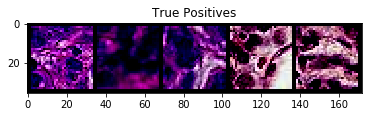

In [103]:
if len(true_positives):
    display_image_batch(torchvision.utils.make_grid(true_positives[:5]), title="True Positives")

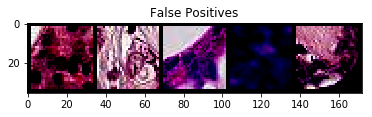

In [104]:
if len(false_positives):
    display_image_batch(torchvision.utils.make_grid(false_positives[:5]), title="False Positives")

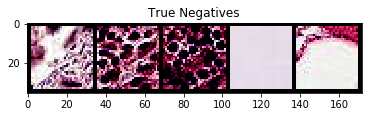

In [105]:
if len(true_negatives):
    display_image_batch(torchvision.utils.make_grid(true_negatives[:5]), title="True Negatives")

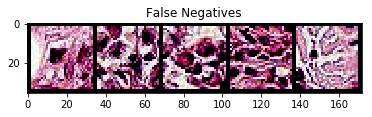

In [106]:
if len(false_negatives):
    display_image_batch(torchvision.utils.make_grid(false_negatives[:5]), title="False Negatives")

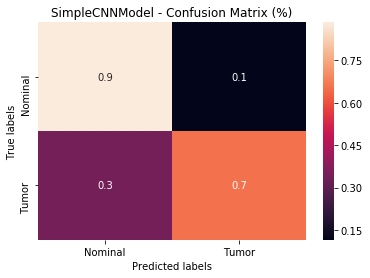

In [107]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt = '.1f', ax=ax)
ax.set_title('SimpleCNNModel - Confusion Matrix (%)')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Nominal', 'Tumor'])
ax.yaxis.set_ticklabels(['Nominal', 'Tumor', ]);

In [108]:
false_positive_rate, true_positive_rate, threshold = roc_curve(labels.numpy(), preds.numpy())
area_under_curve = auc(false_positive_rate, true_positive_rate)

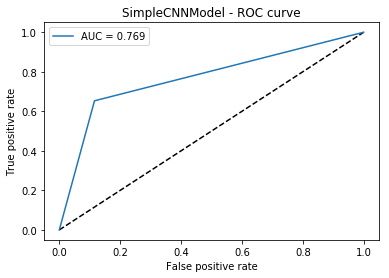

In [109]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('SimpleCNNModel - ROC curve')
plt.legend(loc='best')

## Experiment 2 - ResNet 18

### Resnet18: Prepare the model and training conditions

In [110]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),  # The input size of Resnet18
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # TODO calculate the dataset per-channel mean and stddev
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validate': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataloader_params = {
    "batch_size": 256,  # Increasing this will yield a CUDA Out-Of-Memory exception
    "shuffle": True,
    "num_workers": 8,
}
dataloaders = get_image_dataloaders(DATA_DIR, transforms=data_transforms, **dataloader_params)

### Prepare the model and training conditions

In [111]:
model_ft = get_resnet18()

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# Display model layers
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

#### Optional: Load a previously trained model from disk


In [ ]:
model_ft = load_model(model_ft, 'resnet18')

### Train the model

In [112]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


Epoch: 0 Training Batch: 200 Loss: 0.44378983974456787 Acc: 0.7906560945273632
Epoch: 0 Training Batch: 400 Loss: 0.41245009670233784 Acc: 0.8111069981296758
Epoch: 0 Training Batch: 600 Loss: 0.3948666664110047 Acc: 0.8217684068219634
train Loss: 0.38820982701899925 Acc: 0.8257215431562079


validate Loss: 0.5610656800635546 Acc: 0.7669814747548129

Epoch 1/4
----------


Epoch: 1 Training Batch: 200 Loss: 0.33192796523298196 Acc: 0.859336131840796
Epoch: 1 Training Batch: 400 Loss: 0.321809720926154 Acc: 0.8635345230673317
Epoch: 1 Training Batch: 600 Loss: 0.3155658141943857 Acc: 0.8666220361896838
train Loss: 0.312658611261802 Acc: 0.8680282082317575


validate Loss: 3.3796471731904374 Acc: 0.6667045041772611

Epoch 2/4
----------


Epoch: 2 Training Batch: 200 Loss: 0.28868243884091355 Acc: 0.8784981343283582
Epoch: 2 Training Batch: 400 Loss: 0.2817488816239293 Acc: 0.882442331670823
Epoch: 2 Training Batch: 600 Loss: 0.2761103074731129 Acc: 0.8852043469217971
train Loss: 0.2742677287273325 Acc: 0.886434022627957


validate Loss: 0.33661890527875565 Acc: 0.8533645114420632

Epoch 3/4
----------


Epoch: 3 Training Batch: 200 Loss: 0.254303718606631 Acc: 0.896474657960199
Epoch: 3 Training Batch: 400 Loss: 0.2524529429445243 Acc: 0.8974244077306733
Epoch: 3 Training Batch: 600 Loss: 0.24857389919472217 Acc: 0.8985934900166389
train Loss: 0.24762516130687176 Acc: 0.8987708621012973


validate Loss: 0.32311531311375336 Acc: 0.8652379222666182

Epoch 4/4
----------


Epoch: 4 Training Batch: 200 Loss: 0.2335164978433011 Acc: 0.9047535758706468
Epoch: 4 Training Batch: 400 Loss: 0.2327423708843174 Acc: 0.9058506078553616
Epoch: 4 Training Batch: 600 Loss: 0.23019226954106284 Acc: 0.9067179700499168
train Loss: 0.22979103591341213 Acc: 0.9071810520693045


validate Loss: 0.4338097690756521 Acc: 0.8082319288049401

Training complete in 100m 31s
Best val Acc: 0.865238


### Optional, save the model

In [ ]:
save_model(model_ft, 'resnet18')

### Validate the model

In [113]:
inputs, labels, preds = validate_model(model_ft, dataloaders['validate'], num_batches=5)

In [114]:
true_positives = inputs[(preds == labels) & (preds == 1)]
false_positives = inputs[(preds > labels)]
true_negatives = inputs[(preds == labels) & (preds == 0)]
false_negatives = inputs[(preds < labels)]

cm = confusion_matrix(labels.numpy(), preds.numpy())
# Normalize the cells so that we display percentages instead of counts
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

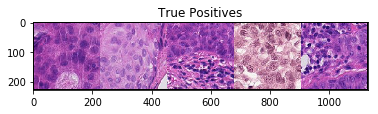

In [115]:
if len(true_positives):
    display_image_batch(torchvision.utils.make_grid(true_positives[:5]), title="True Positives")

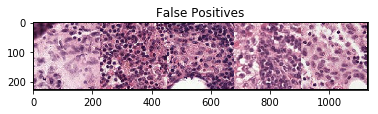

In [116]:
if len(false_positives):
    display_image_batch(torchvision.utils.make_grid(false_positives[:5]), title="False Positives")

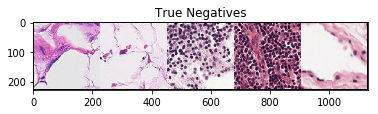

In [117]:
if len(true_negatives):
    display_image_batch(torchvision.utils.make_grid(true_negatives[:5]), title="True Negatives")

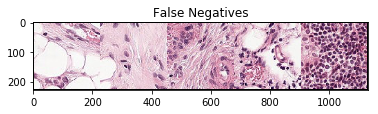

In [118]:
if len(false_negatives):
    display_image_batch(torchvision.utils.make_grid(false_negatives[:5]), title="False Negatives")

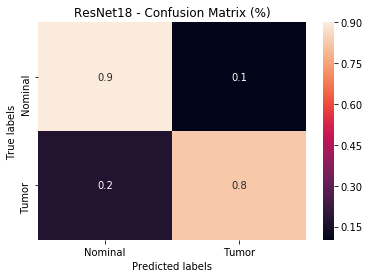

In [119]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt = '.1f', ax=ax)
ax.set_title('ResNet18 - Confusion Matrix (%)')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Nominal', 'Tumor'])
ax.yaxis.set_ticklabels(['Nominal', 'Tumor', ]);

In [120]:
false_positive_rate, true_positive_rate, threshold = roc_curve(labels.numpy(), preds.numpy())
area_under_curve = auc(false_positive_rate, true_positive_rate)

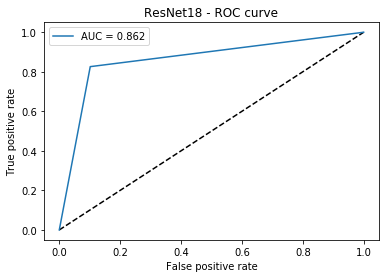

In [121]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ResNet18 - ROC curve')
plt.legend(loc='best')